# LINMA2222 - Stochastic Optimal Control & Reinforcement Learning
## Portfolio optimal strategy
---

### Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)  # For reproducibility

### Constants

In [7]:
THETA = 0.5
W_A = 0.1
W_U = 0.2
SIGMA_A = 0.018
SIGMA_P = 0.02
BETA_U = -0.048
GAMMA_U = 0.06

### Plot functions

In [8]:
def generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=1, xi_a=None, xi_p=None):
    """Generate the state variables x_t and actions u_t for t=0,...,T
       using the given policy.

    Args:
        policy: a function that takes in the current state x_t and returns an action u_t
        x0 (ndarray): initial state. Defaults to 0.
        T (int): number of time steps. Defaults to 1000.
    """
    x = np.zeros((T+1, 3, N))  # State variables: q_t, za_t, zu_t
    u = np.zeros((T, N))       # Actions
    x[0] = np.array(x0).reshape(3, 1)
    if xi_a is None:  xi_a = rng.normal(0, 1, size=(T, N))
    if xi_p is None:  xi_p = rng.normal(0, 1, size=(T, N))

    for t in range(T):
        u[t] = policy(x[t])
        x[t+1, 0] = x[t, 0] + u[t] # q_t
        x[t+1, 1] = (1 - W_A) * x[t, 1] + W_A * SIGMA_A * xi_a[t]  # za_t
        x[t+1, 2] = (1 - W_U) * x[t, 2] + W_U * BETA_U * u[t]  # zu_t

    return x, u, xi_p


def g(q, za, zu , u, xi_p=None):
    """Compute the gross stage reward at each time given state x and action u."""
    # q, za, zu = x[:, 0], x[:, 1], x[:, 2]
    if xi_p is None:
        xi_p = rng.normal(0, 1, size=q.shape[0])

    # Formula found by replacing p_t+1 and p_t by their expressions in the given model (see Question 2.3)
    return q * (za + zu + (GAMMA_U * u) + (SIGMA_P * xi_p)) + THETA * u * (za + zu + (SIGMA_P * xi_p))


def c(g):
    """Compute the net stage reward given gross stage reward g_t for each time t"""
    return np.maximum(g - (np.pow(g, 2) / 2), 1 - np.exp(-g))

def reward(x, u, xi_p, t):
    """Compute all the rewards over the trajectory given states x and actions u from time 0 to t."""
    """returns an array of shape (t,)"""
    g_t = g(x[:t, 0], x[:t, 1], x[:t, 2], u[:t], xi_p=xi_p[:t])
    c_t = c(g_t)
    return c_t

def average_reward(x, u, xi_p, t):
    return np.mean(reward(x, u, xi_p, t))


def generate_trajectories_and_avg_reward(policy, x0=(0, 0, 0), T=1000, N=1):
    """compute efficienctly the average reward over T time steps

    Args:
        policy: a function that takes in the current state x_t and returns an action u_t
        x0 (ndarray): initial state. Defaults to 0.
        T (int): number of time steps. Defaults to 1000.
    """
    u = 0
    x = np.zeros(3)

    total_reward = 0
    for t in range(T):
        u = policy(x)
        x[0] = x[0] + u # q_t
        x[1] = (1 - W_A) * x[1] + W_A * SIGMA_A * rng.normal(0, 1)  # za_t
        x[2] = (1 - W_U) * x[2] + W_U * BETA_U * u  # zu_t
        g_t = g(x[0], x[1], x[2], u, xi_p=rng.normal(0, 1))
        c_t = c(g_t)
        total_reward += c_t
    return total_reward / T


def plot_trajectories(x, u, xi_p, filename=None, mean=False, variance=False):
    """Plot the trajectories of the state variables and actions over time in a 2x2 grid
       and add an additional plot for the average reward as a function of time."""
    
    print(f"Plotting {filename} : reward = {average_reward(x, u, xi_p, x.shape[0]-1)}")
    
    T = x.shape[0] - 1
    time = np.arange(T+1)

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].plot(time, x[:, 0], label=r'$q_t$', color='blue')
    if mean:
        axs[0, 0].hlines(np.mean(x[:, 0]), 0, T, colors='darkblue', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 0].fill_between(time, np.mean(x[:, 0]) - np.std(x[:, 0]), np.mean(x[:, 0]) + np.std(x[:, 0]), color='cyan', alpha=0.3, label='Variance')
    axs[0, 0].set_title(r'$q_t$')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel(r'$q_t$')
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(time, x[:, 1], label=r'$z^{a}_{t}$', color='orange')
    if mean:
        axs[0, 1].hlines(np.mean(x[:, 1]), 0, T, colors='darkorange', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 1].fill_between(time, np.mean(x[:, 1]) - np.std(x[:, 1]), np.mean(x[:, 1]) + np.std(x[:, 1]), color='moccasin', alpha=1, label='Variance')
    axs[0, 1].set_title(r'$z^{a}_{t}$')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel(r'$z^{a}_{t}$')
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(time, x[:, 2], label=r'$z^{u}_{t}$', color='green')
    if mean:
        axs[1, 0].hlines(np.mean(x[:, 2]), 0, T, colors='darkgreen', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 0].fill_between(time, np.mean(x[:, 2]) - np.std(x[:, 2]), np.mean(x[:, 2]) + np.std(x[:, 2]), color='lightgreen', alpha=1, label='Variance')
    axs[1, 0].set_title(r'$z^{u}_{t}$')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel(r'$z^{u}_{t}$')
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(time[:-1], u, label=r'$u_{t}$', color='red')
    if mean:
        axs[1, 1].hlines(np.mean(u), 0, T-1, colors='darkred', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 1].fill_between(time[:-1], np.mean(u) - np.std(u), np.mean(u) + np.std(u), color='lightcoral', alpha=1, label='Variance')
    axs[1, 1].set_title(r'$u_{t}$')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel(r'$u_{t}$')
    axs[1, 1].grid()
    axs[1, 1].legend()

    plt.tight_layout()
    if filename:
        plt.savefig("figures/" + filename + "_states_actions.svg", format='svg')
    plt.show()

    # plot_average_reward(x, u, xi_p, T=T, filename=filename)







def plot_average_reward(x, u, xi_p, T=1000, filename=None):
    # Plot average reward as a function of time
    avg_rewards = [np.mean(reward(x, u, xi_p, t)) for t in range(1, T+1)]
    
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(1, T+1), avg_rewards, label='Average Reward', color='purple')
    plt.title('Average Reward Over Time')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid()

    plt.legend()
    if filename:
        plt.savefig("figures/" + filename + "_average_reward.svg", format='svg')
    plt.show()



### Question 3.1

$\pi_{cl}(x_t) = K_{cl} x_t$


Plotting question_3_1_1_unclipped : reward = 1.5904575403918908e-05


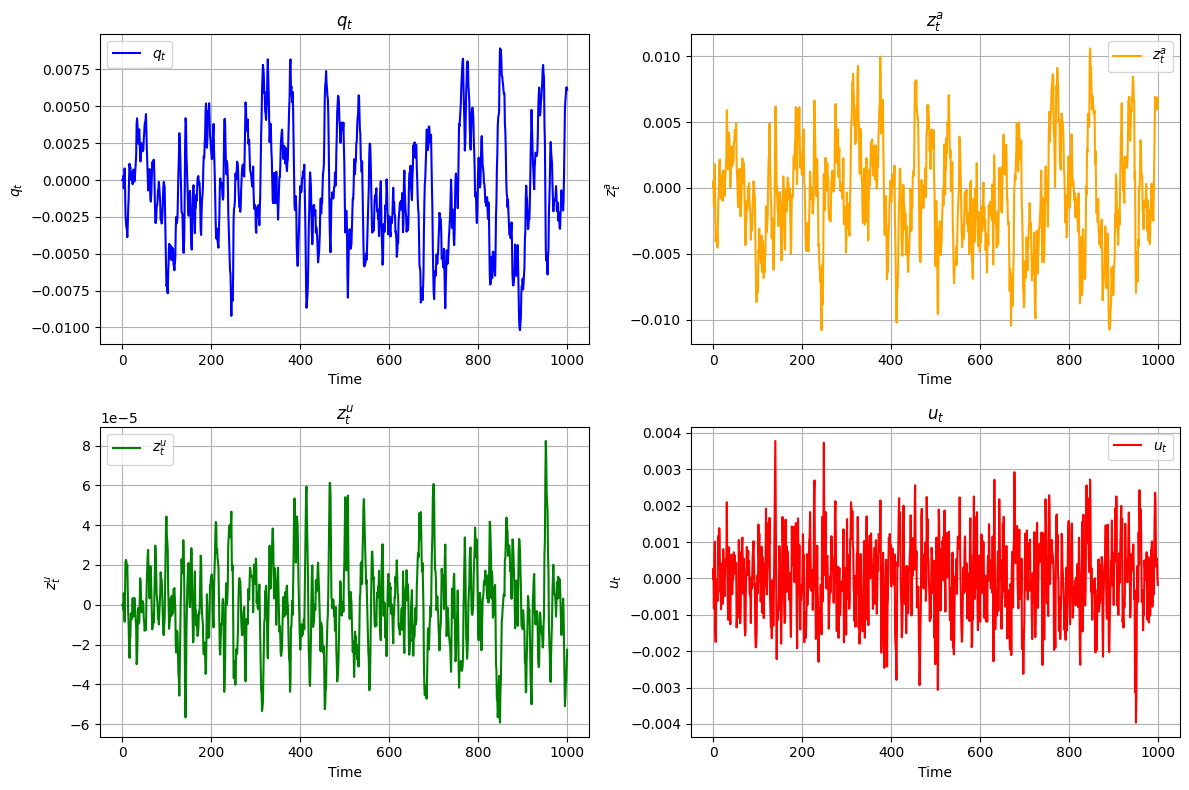

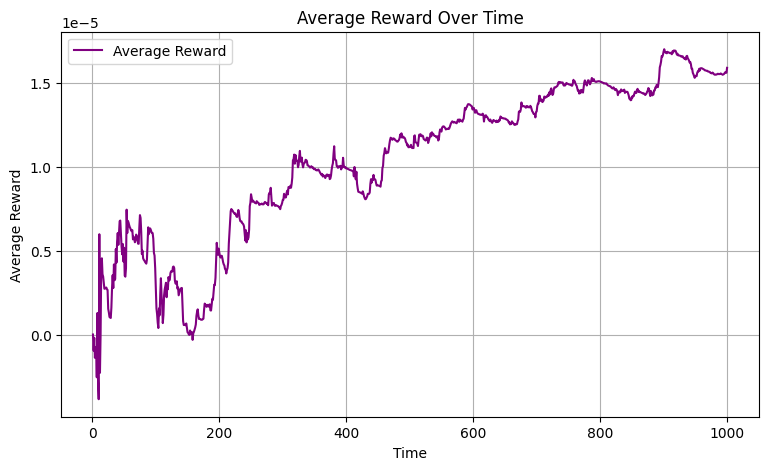

Plotting question_3_1_1_clipped : reward = 1.0538508822918811e-05


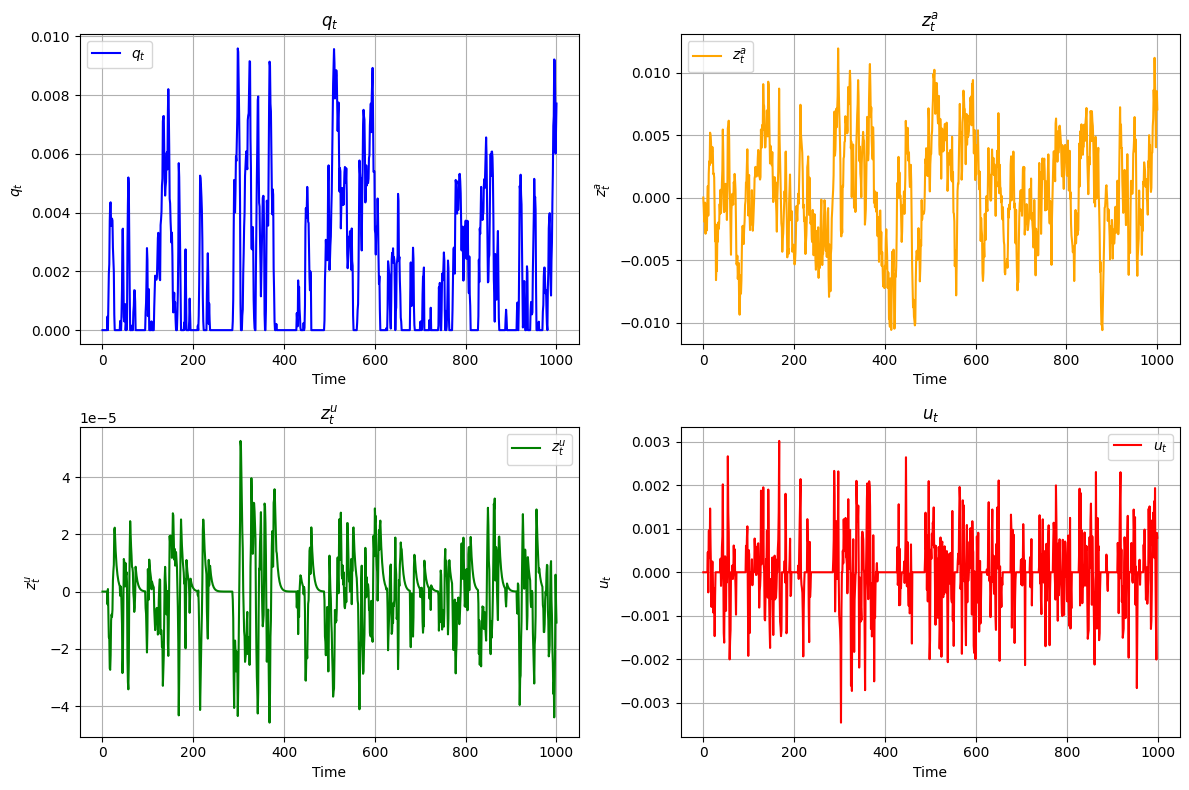

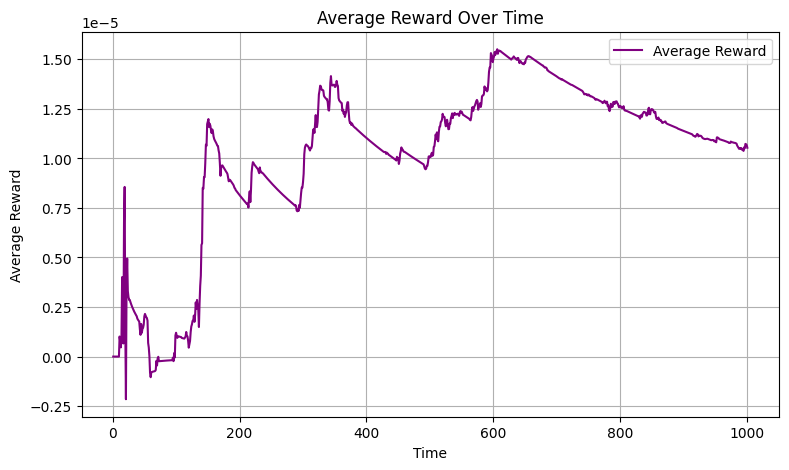

Plotting question_3_1_1_random : reward = 0.0001675774453036412


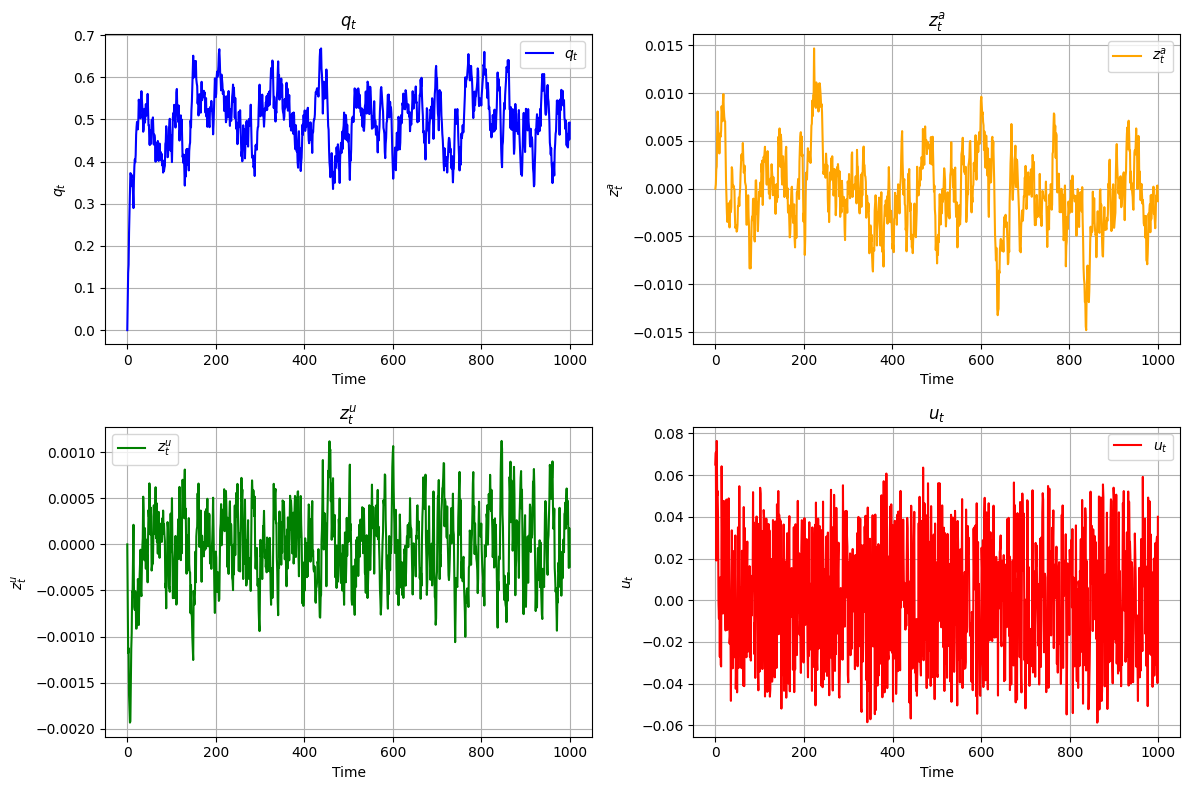

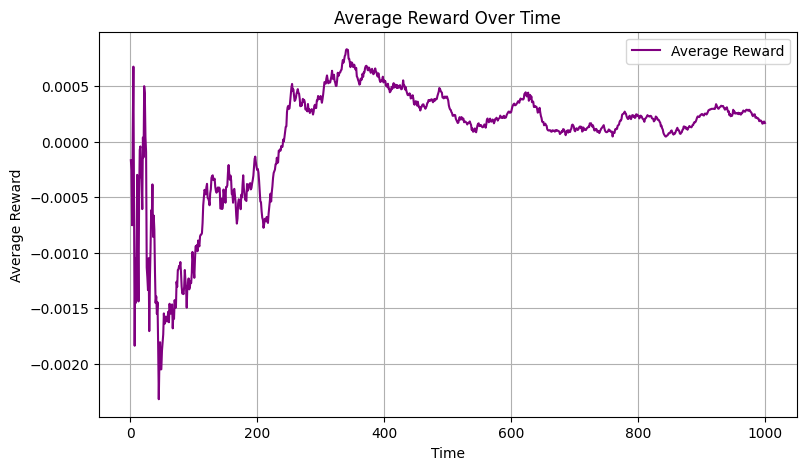

In [ ]:
rng = np.random.default_rng(42)  # For reproducibility

# Question 3.1.1
policy = lambda x: -0.5 * x[0] + 0.5 * x[1] + 0.5 * x[2]
cliped_policy = lambda x: np.clip(policy(x), -x[0], 1-x[0])
random_policy = lambda x: rng.uniform(-x[0] * 0.1, (1 - x[0]) * 0.1)

x, u, xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_1_unclipped")
plot_average_reward(x, u, xi_p, filename="question_3_1_1_unclipped")

x, u, xi_p = generate_trajectories(cliped_policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_1_clipped")
plot_average_reward(x, u, xi_p, filename="question_3_1_1_clipped")

# x, u, xi_p = generate_trajectories(random_policy, x0=(0, 0, 0), T=1000)
# plot_trajectories(x, u, xi_p, filename="question_3_1_1_random")
# plot_average_reward(x, u, xi_p, filename="question_3_1_1_random")

policy_list = [(policy, "Initial Policy"), (cliped_policy, "Clipped Initial Policy")]



In [40]:
### simulate trajectories and plot the average reward over time

rng = np.random.default_rng(42)  # For reproducibility

# Question 3.1.2
N = 1000
def run_trajectories(policy, N=1000, name="policy", show_all=False):
    """Run N trajectories using the given policy and plot the average reward over time."""
    if show_all:
        all_x = np.zeros(( 1001, 3, N))
        all_u = np.zeros((1000, N))
        all_xi_p = np.zeros((1000, N))

    all_rewards = np.zeros((1000, N))

    # for i in range(N):
    #     x, u, xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000)
    #     if show_all:
    #         all_x[i] = x
    #         all_u[i] = u
    #         all_xi_p[i] = xi_p
    #     all_rewards[i] = reward(x, u, xi_p, 1000)

    all_x, all_u, all_xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=N)
    all_rewards = reward(all_x[:, :, :], all_u[:, :], all_xi_p[:, :], 1000).T

    reward_mean = np.mean(all_rewards, axis=0) # average reward for each time step

    print(f"Average reward of {name} over {N} trajectories: {np.mean(all_rewards)} and std: {np.std(all_rewards)}")


    ### Cumulative reward
    plt.figure(figsize=(9, 5))
    for i in range(N):
        plt.plot(np.arange(1, 1001), np.cumsum(all_rewards[i]) / (np.arange(1, 1001)), color='gray', alpha=0.05)
    plt.plot(np.arange(1, 1001), np.cumsum(reward_mean) / (np.arange(1, 1001)), label='Average Reward', color='purple')
    plt.title(f'Average Reward of {name} Over Time ({N} trajectories)')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid()
    # Save cumulative reward plot
    filename_safe = name.replace(" ", "_").lower()
    plt.savefig(f"figures/{filename_safe}_cumulative_reward_{N}_trajectories.svg", format='svg')
    plt.show()


    ### show the reward distribution at the final time step
    plt.figure(figsize=(9, 5))
    plt.hist(np.mean(all_rewards, axis=1), bins=50, color='purple', alpha=0.7, density=True)
    reward_final_mean = np.mean(all_rewards[:, -1])
    reward_final_var = np.var(all_rewards[:, -1])
    plt.text(0.02, 0.98, f'Mean: {reward_final_mean:.2e}\nVar: {reward_final_var:.2e}', transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # show the mean as a dashed line
    plt.axvline(reward_final_mean, color='darkviolet', linestyle='dashed', label='Mean')
    plt.legend()

    plt.title(f'Average Reward Distribution of {name} Over {N} trajectories')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.grid()
    # Save final reward distribution plot
    plt.savefig(f"figures/{filename_safe}_final_reward_distribution_{N}_trajectories.svg", format='svg')
    plt.show()


    if show_all:
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        for i in range(N):
            plt.plot(np.arange(1001), all_x[:, 0, i], color='blue', alpha=0.05)
        plt.title(r'$q_t$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$q_t$')
        plt.grid()
        plt.subplot(3, 1, 2)
        for i in range(N):
            plt.plot(np.arange(1001), all_x[:, 1, i], color='orange', alpha=0.05)
        plt.title(r'$z^{a}_{t}$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$z^{a}_{t}$')
        plt.grid()
        plt.subplot(3, 1, 3)
        for i in range(N):
            plt.plot(np.arange(1001), all_x[:, 2, i], color='green', alpha=0.05)
        plt.title(r'$z^{u}_{t}$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$z^{u}_{t}$')
        plt.grid()
        plt.tight_layout()
        # Save state trajectories plot
        plt.savefig(f"figures/{filename_safe}_state_trajectories_{N}_trajectories.svg", format='svg')
        plt.show()

        ### show the distribution of all the state at all the times
        plt.figure(figsize=(12, 8))
        ax1 = plt.subplot(3, 1, 1)
        plt.hist(all_x[:, 0, :].flatten(), bins=50, color='blue', alpha=0.7, weights=np.ones_like(all_x[:, 0, :].flatten()) / all_x[:, 0, :].flatten().size)
        plt.title(r'Distribution of $q_t$ over all trajectories and times')
        plt.xlabel(r'$q_t$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        q_var = np.var(all_x[:, 0, :].flatten())
        q_mean = np.mean(all_x[:, 0, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {q_mean:.2e}\nVar: {q_var:.2e}', transform=ax1.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
        plt.hist(all_x[:, 1, :].flatten(), bins=50, color='orange', alpha=0.7, weights=np.ones_like(all_x[:, 1, :].flatten()) / all_x[:, 1, :].flatten().size)
        plt.title(r'Distribution of $z^{a}_{t}$ over all trajectories and times')
        plt.xlabel(r'$z^{a}_{t}$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        za_var = np.var(all_x[:, 1, :].flatten())
        za_mean = np.mean(all_x[:, 1, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {za_mean:.2e}\nVar: {za_var:.2e}', transform=ax2.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        

        ax3 = plt.subplot(3, 1, 3, sharey=ax1)
        plt.hist(all_x[:, 2, :].flatten(), bins=50, color='green', alpha=0.7, weights=np.ones_like(all_x[:, 2, :].flatten()) / all_x[:, 2, :].flatten().size)
        plt.title(r'Distribution of $z^{u}_{t}$ over all trajectories and times')
        plt.xlabel(r'$z^{u}_{t}$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        zu_var = np.var(all_x[:, 2, :].flatten())
        zu_mean = np.mean(all_x[:, 2, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {zu_mean:.2e}\nVar: {zu_var:.2e}', transform=ax3.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        # Save state and reward distributions plot
        plt.savefig(f"figures/{filename_safe}_state_distributions_{N}_trajectories.svg", format='svg')
        plt.show()



# run_trajectories(policy, N=N, name="unclipped policy", show_all=True)
# run_trajectories(cliped_policy, N=N, name="clipped policy", show_all=True)

# x = np.mean(all_x, axis=0)
# u = np.mean(all_u, axis=0)
# xi_p = np.mean(all_xi_p, axis=0)
# r = np.mean(reward(x, u, xi_p, 1000))

# plot_trajectories(x, u, xi_p,  filename="question_3_1_2", mean=True, variance=True)


In [6]:
# reset best policy search
best_policy = None
best_reward = -np.inf
best_params = None

In [7]:
# Finding the best policy by random search



range_params = 1.0

def test_policy(policy, N=1000):
    reward_value = 0
    all_x, all_u, all_xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=N)
    all_rewards = reward(all_x[:, :, :], all_u[:, :], all_xi_p[:, :], 1000).T
    reward_value = np.mean(all_rewards)
    return reward_value

def get_linear_policy(params):
    return lambda x: np.clip(params @ np.array([x[0], x[1], x[2]]) , -x[0], 1 - x[0])

def linear_function(params, N=100): # linear function
    policy = get_linear_policy(params)
    reward_value = test_policy(policy, N=N)
    return reward_value

def get_quadratic_policy(params):
    return lambda x: np.clip(params @ np.array([x[0], x[1], x[2], x[0]**2, x[1]**2, x[2]**2, x[0]*x[1], x[0]*x[2], x[1]*x[2], np.ones_like(x[0])])
                               , -x[0], 1 - x[0])

def quadratic_function(params, N=100): # 10 params
    # quadratic function
    policy = get_quadratic_policy(params)
    reward_value = test_policy(policy, N=N)
    return reward_value




In [8]:
#### SCIPY NOT WORKING WELL


# # Advanced optimization for policy search (example: Differential Evolution and Bayesian Optimization)
# from scipy.optimize import differential_evolution

# if target_function == linear_function:
#     param_bounds = [(-100.0, 100.0)] * 3
# else:
#     param_bounds = [(-100.0, 100.0)] * 10


# # result = differential_evolution(lambda params: -target_function(params), param_bounds, seed=42, maxiter=100, polish=True)
# # print in real time the progress of the optimization
# result = differential_evolution(lambda params: -target_function(params, N=1000),  param_bounds, seed=42, maxiter=100, 
#                                 polish=True, callback=lambda x, f: print(f"Current best reward: {-f} with params: {" ".join([f'{p:.4f}' for p in x])}"))
# best_params_de = result.x

# print('Best reward (DE):', -result.fun)
# print('Best params (DE):', result.x)
# print(f"ALL outputs : {result}")


# # Best reward (DE): 0.00014893476071625646
# # [-0.03010771  0.98899323  0.30023768  0.02542109 -0.11388999  0.04947695 0.75390886 -0.4405498   0.30153338  0.00570656]
# # [-0.03502989  0.93203422  0.85333061  0.02800826 -0.38609742 -0.41453566  0.58533717  0.38185557 -0.93132613  0.0058954 ]
# #Average reward of best policy (DE) over 1000 trajectories: 0.00012731321932935195 and std: 0.004505140123694079

# # [-0.0326857   0.99948075 -0.83836307  0.01297369 -0.32935196 -0.16898026 0.93881118  0.74922339  0.13095927  0.01325202]
# # Average reward of best policy (DE) over 1000 trajectories: 0.00013211187504596597 and std: 0.010698030071014887


# # Best params (DE): [ 4.12655385e-04  9.14383436e+00  5.07172512e-01 -1.21986547e-01
# #   3.11259952e+00 -2.23009240e+00  8.06625065e+00 -6.74134828e+00
# #   7.11042371e+00  2.20034138e-02]
# # Average reward of best policy (DE) over 1000 trajectories: 0.0006561312720513467 and std: 0.010407829783256821
 

# best_policy_de = get_quadratic_policy(best_params_de)
# run_trajectories(best_policy_de, N=1000, name="best policy (DE)", show_all=True)

### CMA

In [ ]:
# !pip install cma

import cma

# CMA-ES optimization
es = cma.CMAEvolutionStrategy([0]*3, 1, {'seed': 42,
    'maxfevals': 20000,     
    'popsize':100,           # increase population size for noisy problems
})
### 0.5 is the initial standard deviation, increase it for more exploration
es.optimize(lambda params: -linear_function(params, N=1000))#, verb_disp=1)
# verb_disp=1 to see the progress in real time
best_params_cma = es.result.xbest
best_policy_cma = get_linear_policy(best_params_cma)
policy_list.append((best_policy_cma, "Best linear Policy (CMA-ES)"))
print(f"Best reward : {-es.result.fbest} with params : {' '.join([f'{p:.4f}' for p in es.result.xbest])}")

#[-5.74556410e-03  6.56822157e+00  4.38571108e+00]
# [-2.99189194e-02  3.84492141e+01  3.32209636e+01]
# [-2.97940484e-02  3.14696412e+01  3.27599599e+01] 0.0007577999130319491
# Best reward (CMA-ES): 
# Best params (CMA-ES): 

# Best reward (CMA-ES): 0.0007081507843159959
# Best params (CMA-ES): [-0.03271245 18.91242714 -4.30407586]
# 17 minutes

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 3 (seed=42, Tue Oct  7 16:40:50 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 -1.203538333321593e-04 1.0e+00 1.31e+00  1e+00  2e+00 0:05.3
    2    200 -9.930795238677268e-05 2.0e+00 2.08e+00  1e+00  2e+00 0:10.3
    3    300 -3.486279736656008e-04 2.3e+00 3.32e+00  1e+00  4e+00 0:15.3
    4    400 -6.103587549512187e-04 4.0e+00 5.02e+00  9e-01  7e+00 0:20.3
    5    500 -6.154430866991407e-04 9.1e+00 5.69e+00  5e-01  6e+00 0:26.1
    6    600 -6.062384342047421e-04 1.4e+01 7.20e+00  4e-01  8e+00 0:31.1
    8    800 -6.752029515504350e-04 4.9e+01 1.02e+01  1e-01  8e+00 0:41.5
   10   1000 -7.079115447438663e-04 1.8e+02 1.46e+01  4e-02  9e+00 0:52.0
   12   1200 -7.331874036165857e-04 3.9e+02 3.27e+01  4e-02  2e+01 1:02.6
   14   1400 -7.262974886409908e-04 5.5e+02 3.19e+01  2e-02  1e+01 1:14.0
   17   1700 -7.438598002650321e-04 6.9e+02 3.67e+01  1e-02  6e+00 1:28.8
   20   2000 -7.312262207

/Users/aymeric/miniforge3/lib/python3.12/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.8e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Oct  7 16:56:31 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=182)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


  188  18800 -7.465904565643234e-04 3.2e+00 5.29e+01  6e+01  9e+01 16:11.1
  197  19700 -7.342662392655249e-04 3.9e+00 5.32e+01  4e+01  8e+01 16:57.1
  200  20000 -7.379405783809279e-04 4.2e+00 5.14e+01  3e+01  9e+01 17:13.1
  201  20100 -7.394590366195558e-04 4.8e+00 4.71e+01  2e+01  8e+01 17:18.7
Best reward : 0.0007622866207222104 with params : -0.0529 37.2788 29.9648


In [ ]:
# CMA-ES optimization
es = cma.CMAEvolutionStrategy([0]*10, 1, {'seed': 42, 
    'maxfevals': 20000,     
    'popsize':100,           # increase population size for noisy problems
})
### 0.5 is the initial standard deviation, increase it for more exploration
es.optimize(lambda params: -quadratic_function(params, N=1000))
# verb_disp=1 to see the progress in real time
best_params_cma_quadratic = es.result.xbest
best_policy_cma_quadratic = get_quadratic_policy(best_params_cma_quadratic)
if -es.result.fbest > -0.000005:
    policy_list.append((best_policy_cma_quadratic, "Best quadratic Policy (CMA-ES)"))
print(f"Best reward : {-es.result.fbest} with params : {' '.join([f'{p:.4f}' for p in es.result.xbest])}")
# 21 min

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 10 (seed=42, Tue Oct  7 17:01:33 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 -1.440416409956779e-06 1.0e+00 1.14e+00  1e+00  1e+00 0:06.4
    2    200 -0.000000000000000e+00 1.4e+00 1.36e+00  1e+00  1e+00 0:12.6
    3    300 -7.952440352457939e-07 1.5e+00 1.42e+00  1e+00  2e+00 0:18.7
    4    400 -0.000000000000000e+00 1.7e+00 1.62e+00  1e+00  2e+00 0:24.8
    5    500 -4.840892503394399e-05 1.9e+00 1.53e+00  1e+00  2e+00 0:31.0
    6    600 -1.439360345947923e-05 2.1e+00 1.62e+00  1e+00  2e+00 0:37.0
    7    700 -2.315942025938426e-05 2.1e+00 1.70e+00  1e+00  2e+00 0:43.1
    9    900 -1.926617748965945e-05 2.5e+00 1.85e+00  1e+00  2e+00 0:55.1
   11   1100 -1.029569498283010e-04 3.0e+00 1.97e+00  1e+00  2e+00 1:07.3
   13   1300 -5.330463522188141e-05 3.6e+00 1.96e+00  1e+00  3e+00 1:19.4
   15   1500 -6.052123940560555e-05 4.0e+00 1.72e+00  9e-01  2e+00 1:31.6
   17   1700 -3.35543374

Average reward of best quadratic policy (CMA-ES) over 1000 trajectories: 0.0007356589313495885 and std: 0.011947205584729103


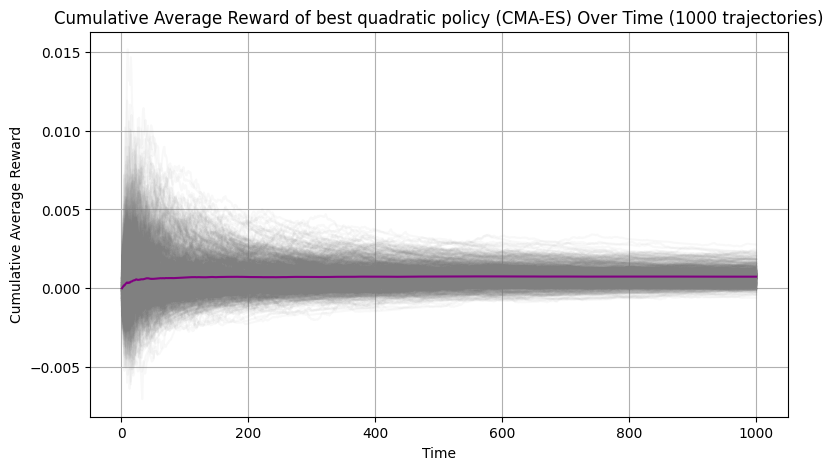

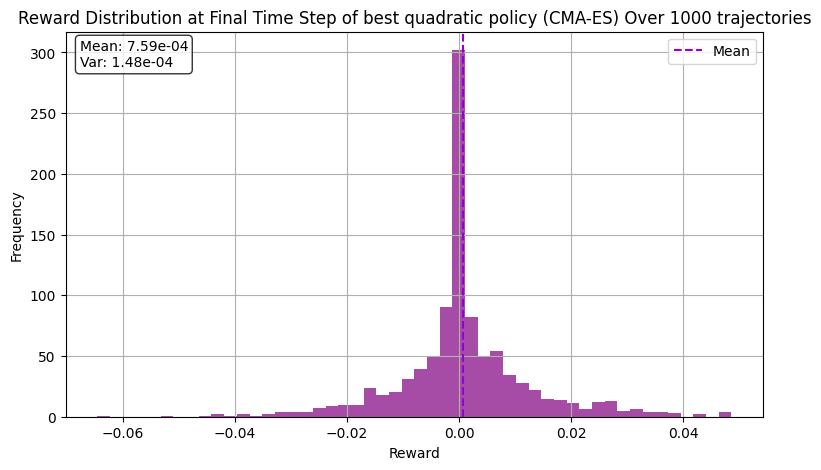

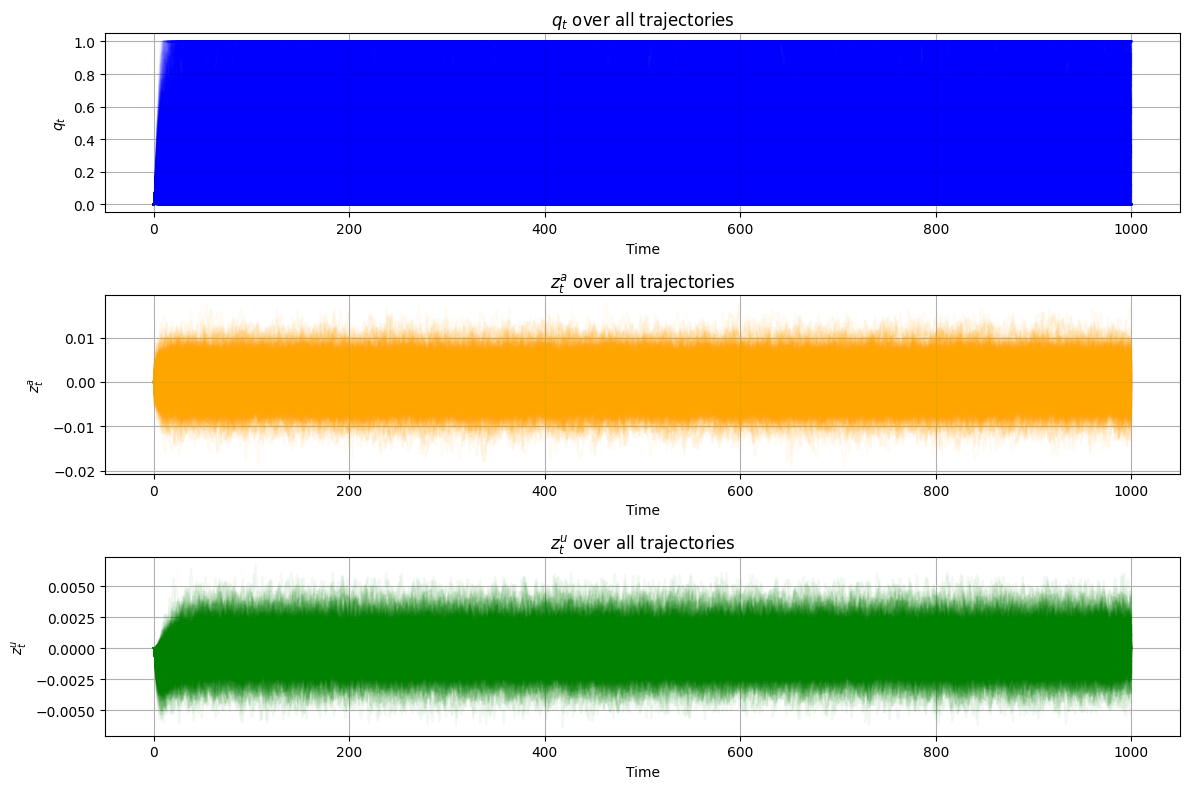

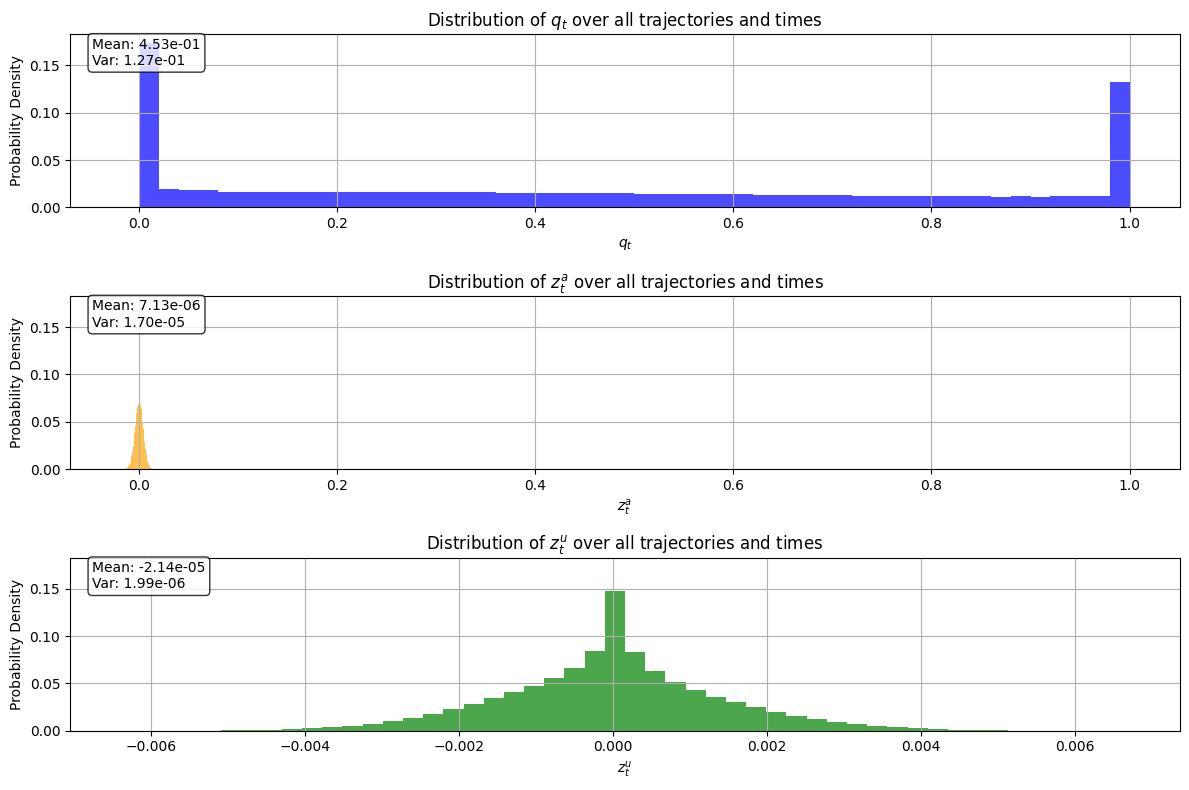

In [ ]:
# print(f"best params (CMA-ES): {best_params_cma}")
# best_policy_cma = get_linear_policy(best_params_cma)
# run_trajectories(best_policy_cma, N=1000, name="best policy (CMA-ES)", show_all=True)

run_trajectories(best_policy_cma_quadratic, N=1000, name="best quadratic policy (CMA-ES)", show_all=True)

Evaluation of all policies over 10000 trajectories ...
Initial Policy                  Average reward = 0.00001453 , Std = 0.00000330
Clipped Initial Policy          Average reward = 0.00000738 , Std = 0.00000270
Best linear Policy (CMA-ES)     Average reward = 0.00069891 , Std = 0.00045730
Best quadratic Policy (CMA-ES)  Average reward = 0.00073159 , Std = 0.00046570


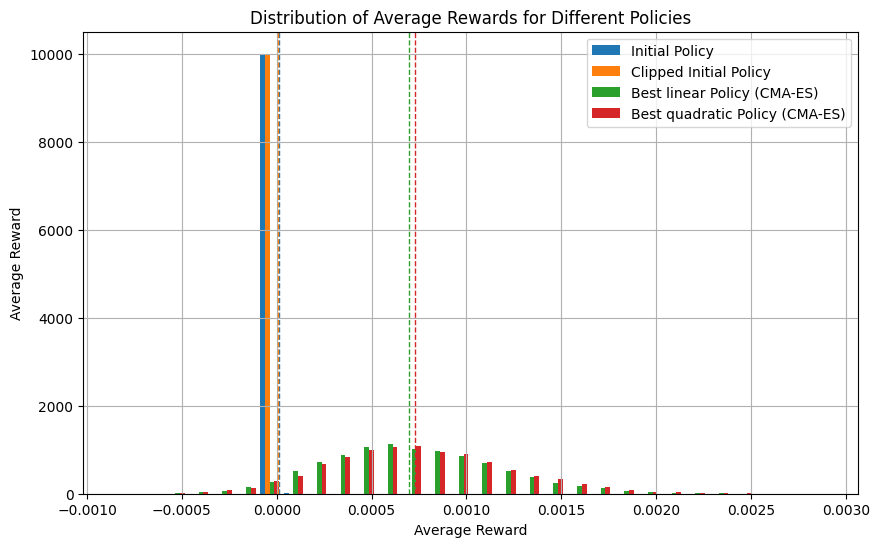

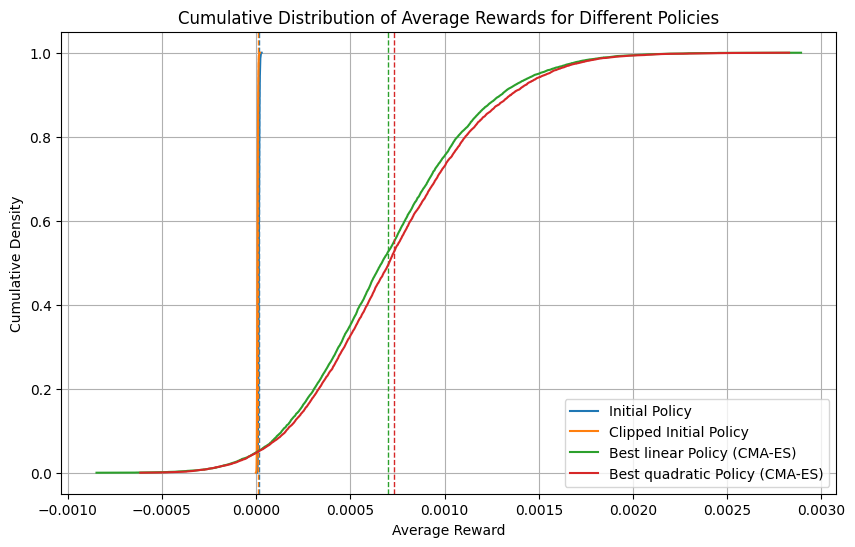

In [17]:
# run for all 3 policies and store the rewards
N = 10000

print(f"Evaluation of all policies over {N} trajectories ...")

all_rewards = np.zeros((len(policy_list), N))
for i in range(len(policy_list)):
    x, u, xi_p = generate_trajectories(policy_list[i][0], x0=(0, 0, 0), T=1000, N=N)
    all_rewards[i] = np.mean(reward(x, u, xi_p, 1000), axis=0).T
    print(f"{policy_list[i][1]:30s}  Average reward = {np.mean(all_rewards[i]):.8f} , Std = {np.std(all_rewards[i]):.8f}")


# plot all the rewards
plt.figure(figsize=(10, 6))
labels = [policy_list[i][1] for i in range(len(policy_list))]
plt.hist(all_rewards.T, bins=30, label=labels, alpha=1)
# add the mean of each distribution
for i in range(all_rewards.shape[0]):
    plt.axvline(np.mean(all_rewards[i]), color=f'C{i}', linestyle='dashed', linewidth=1)
plt.xlabel('Average Reward')

plt.title('Distribution of Average Rewards for Different Policies')
plt.ylabel('Average Reward')
plt.grid()
plt.legend()
plt.show()

# the integral plot
plt.figure(figsize=(10, 6))
for i in range(all_rewards.shape[0]):
    sorted_rewards = np.sort(all_rewards[i])
    cumulative = np.arange(1, len(sorted_rewards) + 1) / len(sorted_rewards)
    plt.plot(sorted_rewards, cumulative, label=labels[i])
    plt.axvline(np.mean(all_rewards[i]), color=f'C{i}', linestyle='dashed', linewidth=1)

plt.xlabel('Average Reward')
plt.title('Cumulative Distribution of Average Rewards for Different Policies')
plt.ylabel('Cumulative Density')
plt.grid()
plt.legend()
plt.show()

In [ ]:

x, u, xi_p = generate_trajectories(best_params_cma_quadratic, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_1_clipped")
plot_average_reward(x, u, xi_p, filename="question_3_1_1_clipped")

# Question 4.4 

Converged after 103 iterations
Riccati equation residual norm: 9.445047909202556e-07
Optimal Gain K_opt: [[ 1.11182191 -2.64863317 -2.52792524]]
Average approximate reward J: 0.0193550622980458
Stable: True
Plotting lqr_optimal_policy : reward = 3.8794733239822546e-05


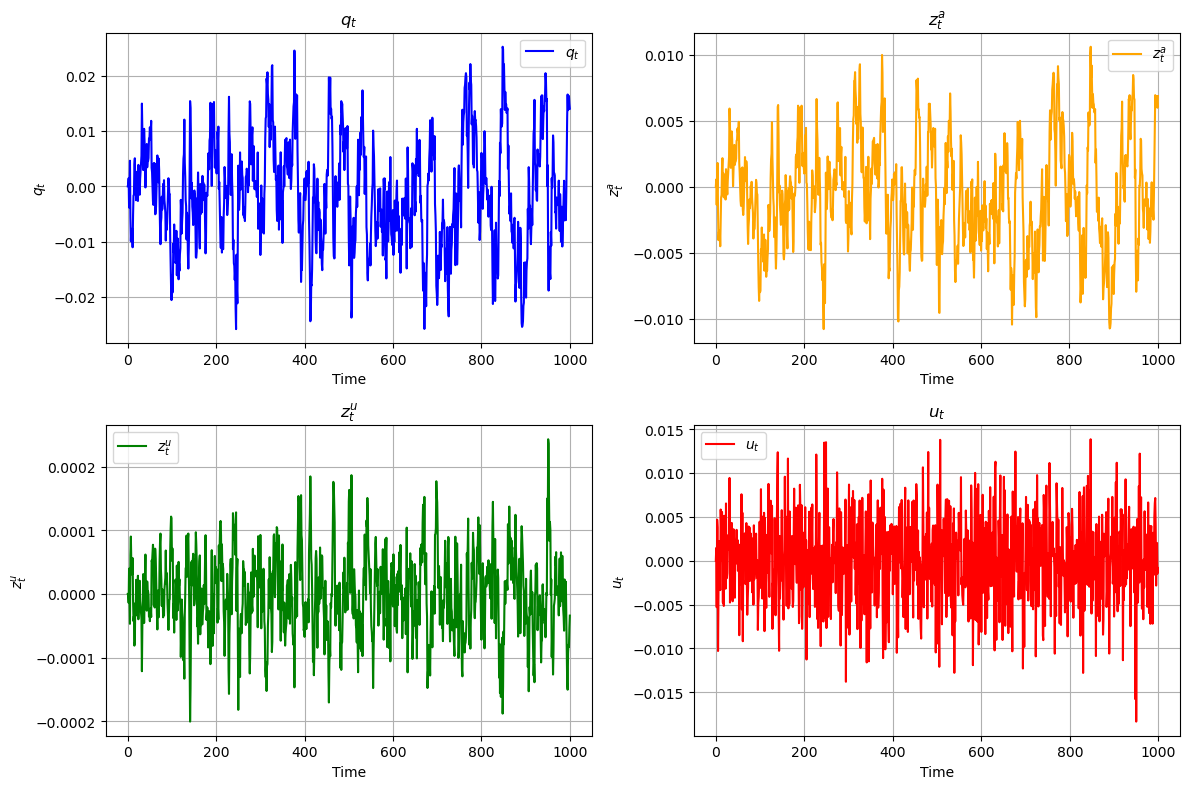

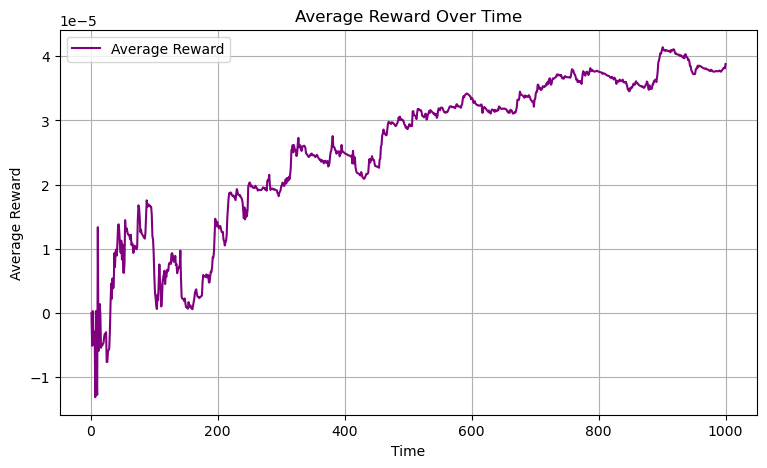

Average reward of LQR Optimal Policy over 1000 trajectories: 3.776438888079346e-05 and std: 0.00019850680136295198


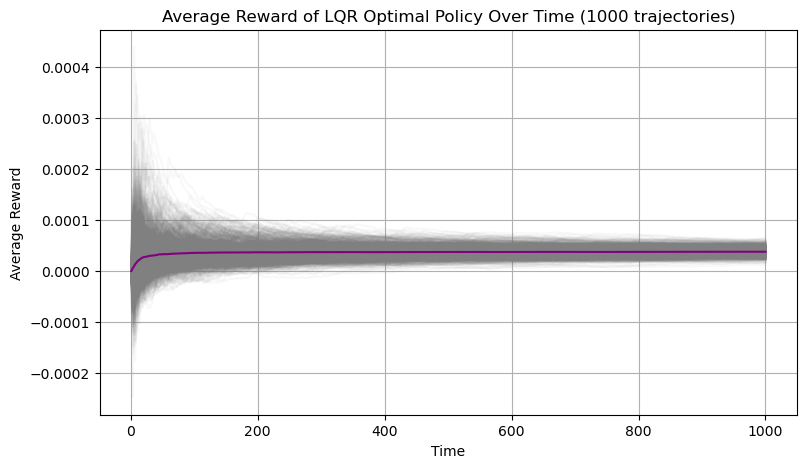

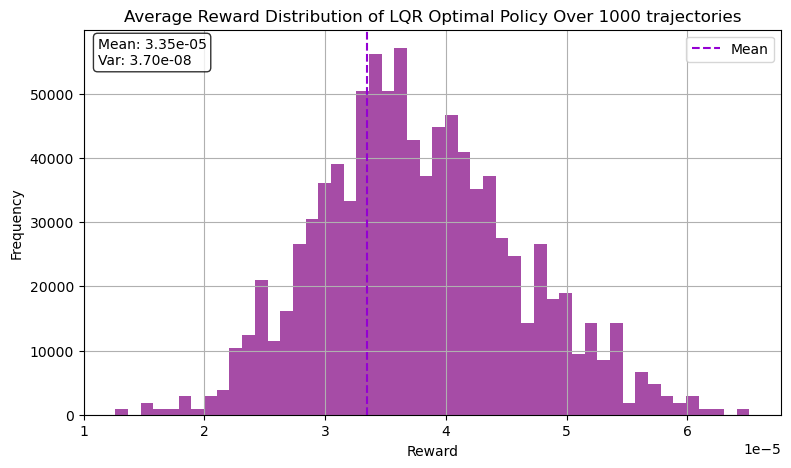

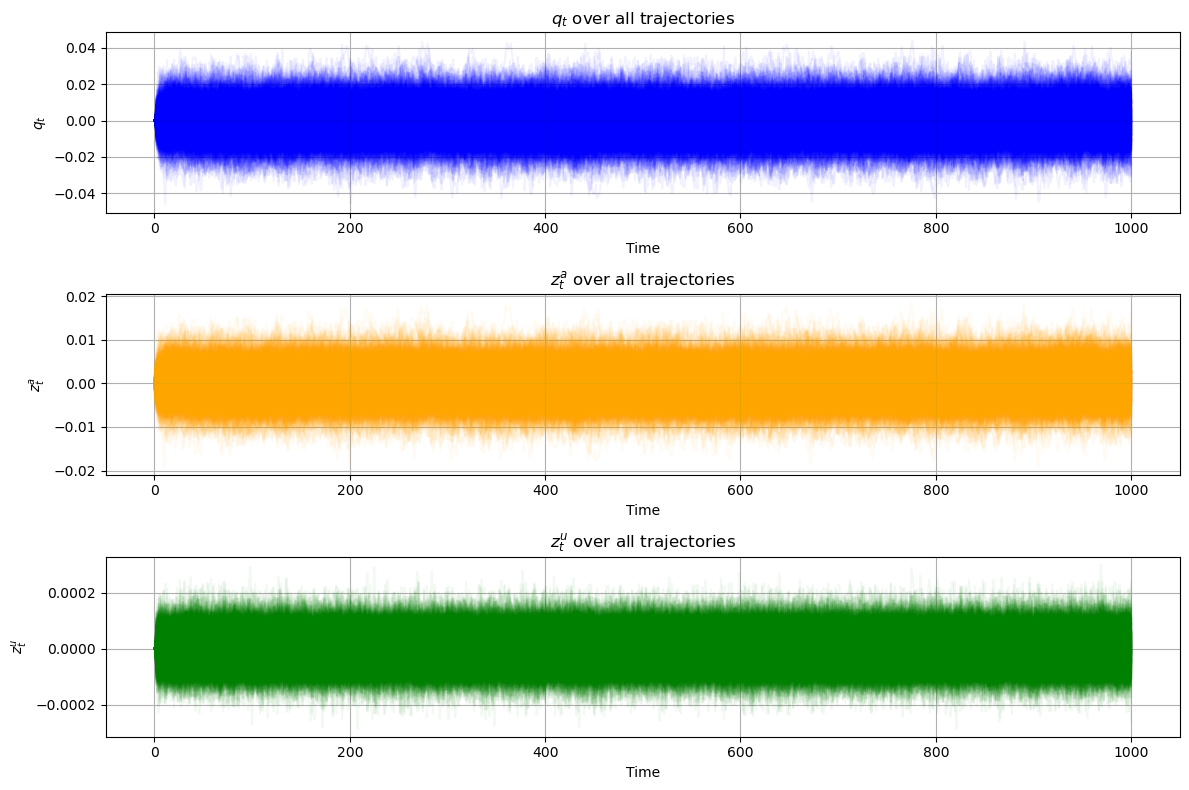

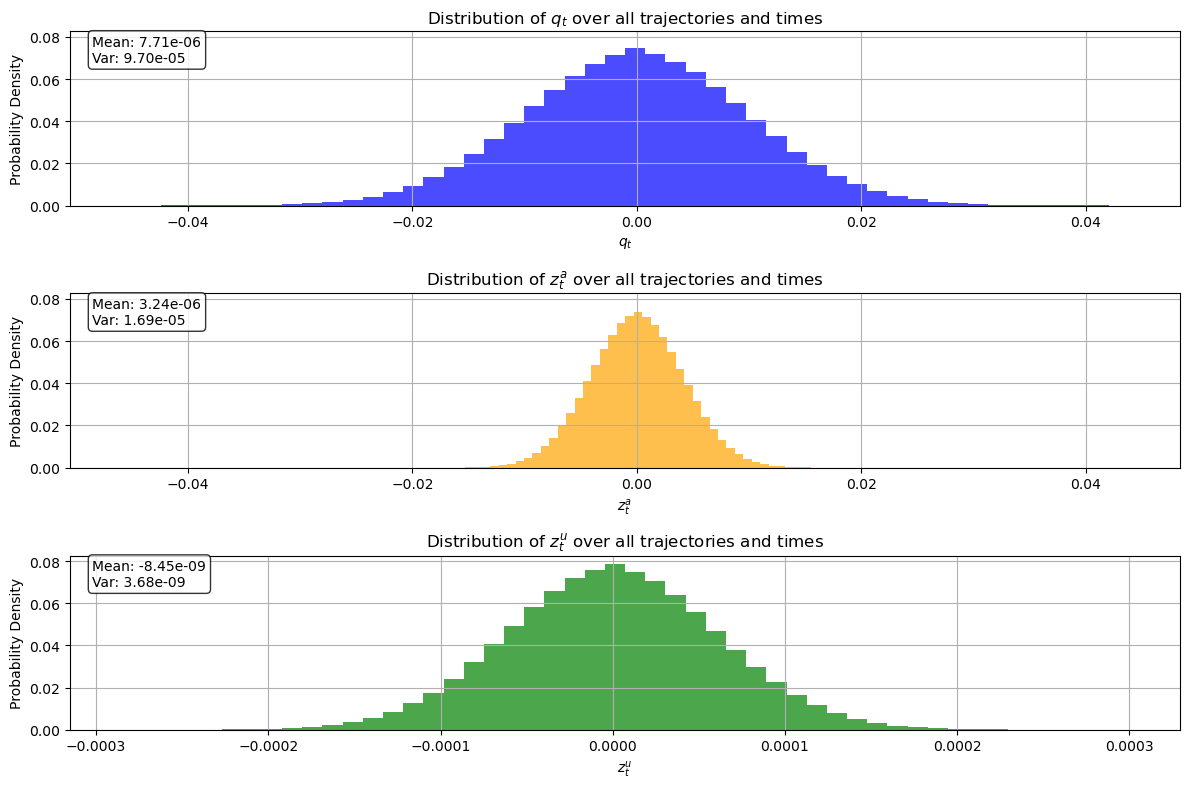

In [41]:
np.random.seed(42)

def solve_ricatti_infinite_horizon(A, B, Q, R, N, max_iterations=1000, tolerance=1e-6):
    """Solve the discrete-time algebraic Riccati equation for infinite horizon LQR.

    Args:
        A (ndarray): State transition matrix.
        B (ndarray): Control input matrix.
        Q (ndarray): State cost matrix.
        R (ndarray): Control cost matrix.
        max_iterations (int): Maximum number of iterations. Defaults to 1000.
        tolerance (float): Convergence tolerance. Defaults to 1e-6.

    Returns:
        (ndarray): Solution to the infinite horizon Riccati equation.
    """
    # Initialize with Q (not zero) for better convergence
    P = Q.copy()
    for i in range(max_iterations):
        # CORRECT Riccati iteration for MINIMIZATION problem
        P_next = Q + A.T @ P @ A - (A.T @ P @ B + N) @ np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A + N.T)

        if np.abs(np.max(P - P_next)) < tolerance:
            print(f"Converged after {i+1} iterations")
            break
        P = P_next
    else:
        print("Warning: Riccati iteration did not converge")
    
    return P

def optimal_gain(A, B, Q, R, N, M):
    """Compute the optimal gain matrix K for LQR given the solution P to the Riccati equation.

    Args:
        A (ndarray): State transition matrix.
        B (ndarray): Control input matrix.
        Q (ndarray): State cost matrix.
        R (ndarray): Control cost matrix.
        N (ndarray): Cross-weighting matrix.
        M (ndarray): Solution to the Riccati equation.

    Returns:
        (ndarray): Optimal state feedback gain matrix.
    """
    K = np.linalg.inv(R + B.T @ M @ B) @ (B.T @ M @ A + N.T)
    return K

# Define system matrices based on the problem description
F = np.array([[1, 0, 0], 
              [0, 1 - W_A, 0], 
              [0, 0, 1 - W_U]])

G = np.array([[1], 
              [0], 
              [W_U * BETA_U]])

D = np.array([[0, 0], [W_A * SIGMA_A, 0], [0, 0]])  # Disturbance matrix
  
# Q = -1/2 S
Q = -np.array([[-((1000 * SIGMA_P)**2), 1000, 1000], 
                     [1000, 0, 0], 
                     [1000, 0, 0]])

# N = -1/2 P
N = -np.array([[1000*GAMMA_U - THETA * ((1000 * SIGMA_P)**2)], 
                     [1000 * THETA], 
                     [1000 * THETA]])
# hat(R) = -1/2 R 
R = (THETA**2) * ((1000 * SIGMA_P)**2)

M = solve_ricatti_infinite_horizon(F, G, Q, R, N)

# Verify residual of Riccati equation
residual = F.T @ M @ F - (F.T @ M @ G + N) @ np.linalg.inv(R + G.T @ M @ G) @ (G.T @ M @ F + N.T) + Q - M
print(f"Riccati equation residual norm: {np.linalg.norm(residual, ord='fro')}")

K_opt = optimal_gain(F, G, Q, R, N, M)

# Print optimal gain
print("Optimal Gain K_opt:", K_opt)

# Compute average approximate reward
J = -1/2 * np.linalg.trace(M @ D @ D.T)
print("Average approximate reward J:", J)


def lqr_policy(x):
    u = -K_opt @ x
    return u


# Check closed-loop stability
F_cl = F - G @ K_opt
eigenvalues = np.linalg.eigvals(F_cl)
print("Stable:", all(np.abs(eigenvalues) < 1))


x, u, xi_p = generate_trajectories(lqr_policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="lqr_optimal_policy")
plot_average_reward(x, u, xi_p, filename="lqr_optimal_policy")
run_trajectories(lqr_policy, N=1000, name="LQR Optimal Policy", show_all=True)